<a href="https://colab.research.google.com/github/AkankshaNarula/YourDoc/blob/main/Unet_for_pneumonia_segmentation_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
iamtapendu_rsna_pneumonia_processed_dataset_path = kagglehub.dataset_download('iamtapendu/rsna-pneumonia-processed-dataset')

print('Data source import complete.')


100%|██████████| 10.9G/10.9G [05:03<00:00, 38.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(iamtapendu_rsna_pneumonia_processed_dataset_path)

/root/.cache/kagglehub/datasets/iamtapendu/rsna-pneumonia-processed-dataset/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/iamtapendu/rsna-pneumonia-processed-dataset/versions/1


stage2_test_metadata.csv  stage2_train_metadata.csv  Test  Training


In [ ]:
def visualize_predictions(dataset, model=None, num_samples=1, threshold=0.5):
    """
    Function to visualize images, ground truth masks, and predicted masks.

    Parameters:
    - model: The trained Keras model (optional).
    - dataset: The test dataset (tf.data.Dataset).
    - num_samples: The number of samples to display (default is 1).
    - threshold: Threshold to binarize the predicted mask (default is 0.5).
    """

    # Iterate through the specified number of samples
    for (image, var), (masks, targets) in dataset.take(1):  # Take only one batch
        for i in range(3, num_samples + 3):  # Iterate over each image in the batch

            # If a model is provided, make predictions
            if model is not None:
                pred_mask, pred_target = model.predict([image[i:i+1], var[i:i+1]])
                # Binarize the predicted mask using the threshold
                binarized_mask = (pred_mask[0] > threshold).astype(np.float32)  # Convert to binary
                show_pred = True  # Indicate that predictions should be displayed
            else:
                show_pred = False  # Do not display predictions

            # Convert the image to uint8 format for proper visualization
            img_to_show = (image[i].numpy() * 255).astype(np.uint8)

            # Visualize the images and both ground truth and predicted masks
            plt.figure(figsize=(10, 6))

            # Original image
            plt.subplot(1, 2 if not show_pred else 3, 1)
            plt.imshow(img_to_show)  # Display the image scaled to [0, 255]
            plt.title('Original Image')
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 2 if not show_pred else 3, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')  # Ensure the mask is 2D
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Predicted binarized mask (only if a model is provided)
            if show_pred:
                plt.subplot(1, 3, 3)
                plt.imshow(binarized_mask.squeeze(), cmap='gray')  # Ensure the prediction is 2D
                plt.title('Predicted Mask (Binarized)')
                plt.axis('off')

            # Display the plot
            plt.tight_layout()
            plt.show()

            # Show the predicted binary target value (if a model is provided)
            if model is not None:
                print(f"Ground Truth Target: {targets[i].numpy()}, Predicted Target: {int(pred_target[0].item() > 0.5)}")
            else:
                print(f"Ground Truth Target: {targets[i].numpy()}, No model predictions available.")


In [ ]:
def plot_learning_curves(history):
    # Plot the loss
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Metrics for the binary target output
    plt.subplot(1, 3, 2)
    plt.plot(history['target_output_accuracy'], label='Training Accuracy')
    plt.plot(history['val_target_output_accuracy'], label='Validation Accuracy')
    plt.title('Binary Target Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0, 1)

    # IoU for the mask output
    plt.subplot(1, 3, 3)
    plt.plot(history.iloc[:, 1], label='Training IoU')
    plt.plot(history.iloc[:, 7], label='Validation IoU')
    plt.title('Mask IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.ylim(0, 1)

    plt.show()

# Data Loading and Preprocessing(tf.Data.Dataset)

## Tabular data

Train, validation and test split:

In [ ]:
df = pd.read_csv(iamtapendu_rsna_pneumonia_processed_dataset_path + '/stage2_train_metadata.csv')
df=df[df['class'].isin(["Lung Opacity","Normal"])].copy()
df.drop(['x', 'y', 'width', 'height','modality','class'],axis=1,inplace=True )
df= df.drop_duplicates()

df_train_val, df_test = train_test_split(df,test_size=0.1,stratify=df["Target"], random_state=42)
df_train, df_val = train_test_split(df_train_val,test_size=0.2,stratify=df_train_val["Target"], random_state=42)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(10700, 5)
(2676, 5)
(1487, 5)


Encode categorical features ('sex' and 'position').

Handle outliers: cap 'age' at a maximum of 90.

In [ ]:
# Mapping dictionaries
sex_mapping = {'M': 0, 'F': 1}
position_mapping = {'AP': 0, 'PA': 1}

# Apply the mapping to the corresponding columns
for df in [df_train, df_val, df_test]:
    df['sex'] = df['sex'].map(sex_mapping)
    df['position'] = df['position'].map(position_mapping)
    df['age'] = df['age'].apply(lambda x: 90 if x > 90 else x)

Scale 'age' to [0,1] using MinMaxScaler.

In [ ]:
scaler = MinMaxScaler()

# Fit the scaler to the 'age' column in the training set
df_train['age'] = scaler.fit_transform(df_train[['age']])

# Apply the same transformation to the validation and test sets
df_val['age'] = scaler.transform(df_val[['age']])
df_test['age'] = scaler.transform(df_test[['age']])

Result:

In [ ]:
df_train.describe()

Target           age           sex      position
count  10700.000000  10700.000000  10700.000000  10700.000000
mean       0.404486      0.496994      0.435514      0.579907
std        0.490815      0.188205      0.495847      0.493597
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.359551      0.000000      0.000000
50%        0.000000      0.516854      0.000000      1.000000
75%        1.000000      0.640449      1.000000      1.000000
max        1.000000      1.000000      1.000000      1.000000

In [ ]:
df_val.describe()

Target          age          sex     position
count  2676.000000  2676.000000  2676.000000  2676.000000
mean      0.404709     0.493127     0.412930     0.563901
std       0.490927     0.189718     0.492452     0.495992
min       0.000000     0.011236     0.000000     0.000000
25%       0.000000     0.348315     0.000000     0.000000
50%       0.000000     0.505618     0.000000     1.000000
75%       1.000000     0.629213     1.000000     1.000000
max       1.000000     1.000000     1.000000     1.000000

In [ ]:
#For debugging
#batch_size = 1
#df_train_final=df_train.iloc[:2].copy()
#df_val_final=df_val.iloc[:2].copy()
#df_test_final=df_test.iloc[:2].copy()
#epochs =1
#steps_per_epoch =1
#validation_steps =1


df_train_final=df_train.copy()
df_val_final=df_val.copy()
df_test_final=df_test.copy()

batch_size = 64
epochs =10
steps_per_epoch =len(df_train_final)//batch_size
validation_steps =len(df_train_final)//batch_size

## Image data

In [ ]:
image_size=224

def augment_image_and_mask(image, mask):
    # Adjust the brightness and contrast of the image
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask


# Function to load images and masks
def load_image_and_mask(image_path, mask_path, new_size=(224, 224), augmentation=0):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    # Resize the image and mask
    image = tf.image.resize(image, new_size)
    mask = tf.image.resize(mask, new_size)

    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0  # Escalar a [0, 1]

    # Normalize the binary mask
    mask = tf.cast(mask, tf.float32)
    mask = tf.where(mask > 0, 1.0, 0.0)  # Convertir valores a 0 y 1

    # Apply data augmentation if the parameter is set to 1
    if augmentation == 1:
        image, mask = augment_image_and_mask(image, mask)

    return image, mask

## Customized Dataset

As our model is multi-input (image, tabular data) and multi-output (mask, target), we customize tf.data.Dataset to meet these requirements, including data loading, preprocessing, and batching.

In [ ]:
!ls /root/.cache/kagglehub/datasets/iamtapendu/rsna-pneumonia-processed-dataset/versions/1

stage2_test_metadata.csv  stage2_train_metadata.csv  Test  Training


In [ ]:
!ls /root/.cache/kagglehub/datasets/iamtapendu/rsna-pneumonia-processed-dataset/versions/1/Training

Images	Masks


In [ ]:
# Working and input directories
output_dir = "/content"
input_dir = iamtapendu_rsna_pneumonia_processed_dataset_path
images_dir = input_dir + "/Training/" + 'Images/'  # Directory containing images
mask_dir = input_dir + "/Training/" + 'Masks/'    # Directory containing masks

In [ ]:
# Dictionaries to store results for each dataset
image_paths = {}      # Dictionary to store image paths
mask_paths = {}       # Dictionary to store mask paths
variables_num = {}    # Dictionary to store numerical variables
target = {}           # Dictionary to store target labels


In [ ]:
# List of datasets (train, validation, test)
datasets = [
    ('train', df_train_final),  # Training dataset
    ('val', df_val_final),      # Validation dataset
    ('test', df_test_final)     # Test dataset
]


In [ ]:
datasets

[('train',
                                    patientId  Target       age  sex  position
  9879   6adaad70-4f68-478b-b489-6824830a7688       0  0.325843    0         1
  8415   5f429cb7-1eb8-4819-8269-02256d91227d       0  0.370787    0         1
  9191   657b1ec2-8f10-4070-bfde-db020bbdb2fe       0  0.168539    0         0
  2134   27b2992d-54c7-4fcd-a060-b118bd8fe5ca       0  0.617978    1         1
  762    0a22297d-22e1-4f3f-aa10-edcd220c1cb0       0  0.483146    1         1
  ...                                     ...     ...       ...  ...       ...
  18304  acf7fc42-fbe5-45d4-b099-6355aab368d8       0  0.494382    1         1
  21007  bec77715-a15a-4725-9adc-792af4dcc1d4       1  0.337079    0         1
  24368  dafc817f-dcd4-41f8-9e0c-9f7ee41d1cf4       1  0.348315    0         0
  21783  c591fcdf-b868-480d-bf34-13ae48de1d64       0  0.449438    0         1
  2882   34ba0b9f-640e-4e8d-9f60-3e6094cd3e50       1  0.224719    0         0
  
  [10700 rows x 5 columns]),
 ('val',


In [ ]:
# Loop through each dataset and populate the dictionaries
for name, df in datasets:
    # Store image paths: concatenate directory with patientId
    image_paths[name] = images_dir + df["patientId"].astype(str) + ".png"

    # Store mask paths: concatenate directory with patientId
    mask_paths[name] = mask_dir + df["patientId"].astype(str)+ ".png"

    # Store numerical variables: extract 'age', 'sex', and 'position' columns
    variables_num[name] = df[["age", "sex", "position"]].values

    # Store target values: extract the 'Target' column
    target[name] = df['Target'].values

In [ ]:
# Verify results
print(image_paths['train'].head())  # Display the first few image paths for training set
print(variables_num['val'][:5])     # Display the first 5 numerical variable rows for validation set
print(target['test'][:5])           # Display the first 5 target values for test set


9879    /root/.cache/kagglehub/datasets/iamtapendu/rsn...
8415    /root/.cache/kagglehub/datasets/iamtapendu/rsn...
9191    /root/.cache/kagglehub/datasets/iamtapendu/rsn...
2134    /root/.cache/kagglehub/datasets/iamtapendu/rsn...
762     /root/.cache/kagglehub/datasets/iamtapendu/rsn...
Name: patientId, dtype: object
[[0.46067416 0.         0.        ]
 [0.33707865 0.         0.        ]
 [0.62921348 0.         0.        ]
 [0.28089888 0.         1.        ]
 [0.5505618  1.         0.        ]]
[0 0 0 0 1]


In [ ]:
def create_dataset(image_paths, mask_paths, variables_num, target, batch_size, augmentation=0, shuffle=False, repeat=False):
    # Load paths, numerical variables, and target values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, variables_num, target))

    # Map function to load and preprocess the data
    dataset = dataset.map(lambda img_path, mask_path, var, tgt:
                          ((load_image_and_mask(img_path, mask_path, augmentation=augmentation)[0], var),  # Input: image and variables
                           (load_image_and_mask(img_path, mask_path, augmentation=augmentation)[1], tgt)))  # Output: mask and target

    # Shuffle only if specified
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Repeat if specified
    if repeat:
        dataset = dataset.repeat()  # Repeat indefinitely

    # Batch and optimize
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(image_paths['train'], mask_paths['train'], variables_num['train'],
                               target['train'], batch_size, augmentation=1, shuffle=True, repeat=True)  # Shuffle enabled and repeat
val_dataset = create_dataset(image_paths['val'], mask_paths['val'], variables_num['val'],
                             target['val'], batch_size, shuffle=False, repeat=True)  # No shuffle, no repeat
test_dataset = create_dataset(image_paths['test'], mask_paths['test'], variables_num['test'],
                              target['test'], batch_size, shuffle=False)  # No shuffle, no repeat


In [ ]:
print(type(mask_paths))


<class 'dict'>


In [ ]:
print(mask_paths.keys())  # See all available keys


dict_keys(['train', 'val', 'test'])


In [ ]:
print(type(mask_paths['train']))


<class 'pandas.core.series.Series'>


In [ ]:
mask_paths['train'] = mask_paths['train'].tolist()
print(mask_paths['train'][0])  # This should work now!


/root/.cache/kagglehub/datasets/iamtapendu/rsna-pneumonia-processed-dataset/versions/1/Training/Masks/6adaad70-4f68-478b-b489-6824830a7688.png


In [ ]:
for batch in train_dataset.take(1):
    (images, variables), (masks, targets) = batch
    print("Images shape:", images.shape)
    print("Variables shape:", variables.shape)
    print("Masks shape:", masks.shape)
    print("Targets shape:", targets.shape)

Images shape: (64, 224, 224, 3)
Variables shape: (64, 3)
Masks shape: (64, 224, 224, 1)
Targets shape: (64,)


# 4. EDA

**Key Findings**
* Image Visualization: Pneumonia-affected areas appear in white on the mask, while healthy chest masks are completely black.
* Target Imbalance: The dataset is imbalanced, requiring a custom loss function to give more weight to the minority class.

## 4.1 Image Visualization

We visualize chest X-ray images and their masks to understand the dataset.

* Example 1: A healthy case with no affected areas in the mask.
* Example 2: A pneumonia case, with the mask highlighting the affected region in white.

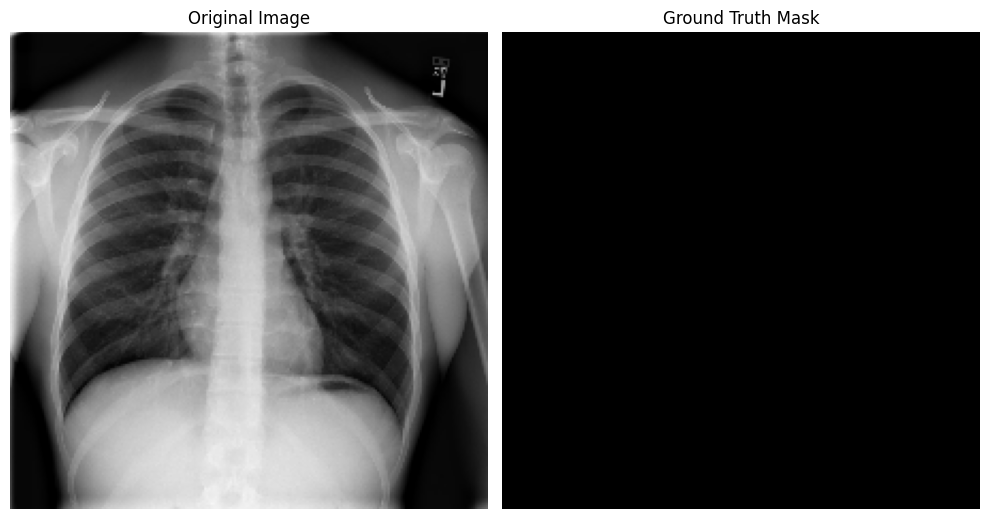

Ground Truth Target: 0, No model predictions available.


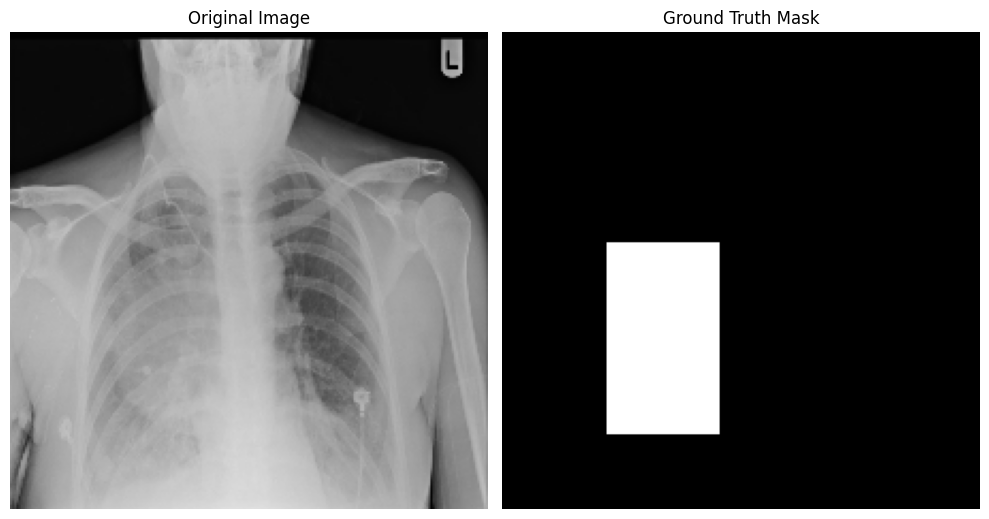

Ground Truth Target: 1, No model predictions available.


In [ ]:
visualize_predictions(dataset=val_dataset, num_samples=2)

## Class Distribution

The target classes are imbalanced, which may negatively impact model training. To address this, we will define a custom loss function to assign greater weight to the minority class.

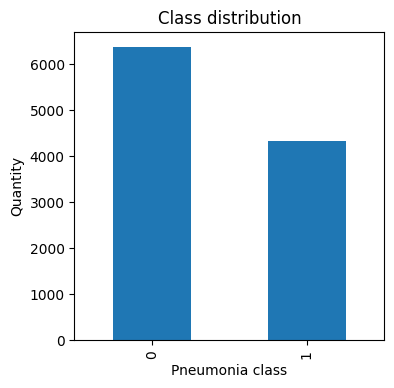

In [ ]:
plt.figure(figsize=(4,4))
df_train_final["Target"].value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.xlabel("Pneumonia class")
plt.ylabel("Quantity")
plt.show()

# Model

## Building Model.

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def residual_block_leaky(input, n_filters):
    res = BatchNormalization()(input)
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = LeakyReLU(negative_slope=0.1)(res)
    res = Conv2D(n_filters, (3, 3), padding='same', use_bias=False)(res)
    res = BatchNormalization()(res)
    res = Add()([res, input])
    res = LeakyReLU(negative_slope=0.1)(res)
    return res

In [ ]:
def unet_hybrid():
    input_im = Input(shape=(image_size, image_size, 3))
    var_input = Input(shape=(3,))

    # Encoder with residual blocks
    conv0 = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_im)
    conv0 = BatchNormalization()(conv0)
    conv0 = LeakyReLU(negative_slope=0.1)(conv0)

    conv1 = Conv2D(32, (3, 3), padding='same', use_bias=False)(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    res1 = residual_block_leaky(pool1, 32)

    conv2 = Conv2D(64, (3, 3), padding='same', use_bias=False)(res1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    res2 = residual_block_leaky(pool2, 64)

    conv3 = Conv2D(128, (3, 3), padding='same', use_bias=False)(res2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    res3 = residual_block_leaky(pool3, 128)

    conv4 = Conv2D(256, (3, 3), padding='same', use_bias=False)(res3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    res4 = residual_block_leaky(pool4, 256)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(negative_slope=0.1)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same', use_bias=False)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = LeakyReLU(negative_slope=0.1)(conv5)
    drop5 = Dropout(0.3)(conv5)

    # Decoder with residual blocks
    up6 = Conv2DTranspose(256, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(drop5)
    up6 = BatchNormalization()(up6)
    up6 = LeakyReLU(negative_slope=0.1)(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    res6 = residual_block_leaky(merge6, 512)

    up7 = Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res6)
    up7 = BatchNormalization()(up7)
    up7 = LeakyReLU(negative_slope=0.1)(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    res7 = residual_block_leaky(merge7, 256)

    up8 = Conv2DTranspose(64, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res7)
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(negative_slope=0.1)(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    res8 = residual_block_leaky(merge8, 128)

    up9 = Conv2DTranspose(32, kernel_size=(2, 2), strides=2, padding='same', use_bias=False)(res8)
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(negative_slope=0.1)(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    res9 = residual_block_leaky(merge9, 64)

    # Process numeric variables
    var_dense = Dense(64, activation='relu')(var_input)  # Capa densa para las variables adicionales
    var_dense = BatchNormalization(momentum=0.9)(var_dense)
    var_reshaped = Reshape((1, 1, 64))(var_dense)
    var_reshaped = UpSampling2D(size=(image_size // 1, image_size // 1))(var_reshaped)  # Ajustar a 224x224

    # Merged output
    merged_output = concatenate([res9, var_reshaped], axis=-1)

    # Output for segmentation
    mask_output = Conv2D(1, (1, 1), activation='sigmoid', name="mask_output")(merged_output)

    # Output for classification
    flatten = GlobalAveragePooling2D()(merged_output)
    dense = Dense(64, use_bias=False)(flatten)
    dense = BatchNormalization()(dense)
    dense = LeakyReLU(negative_slope=0.1)(dense)
    target_output = Dense(1, activation='sigmoid', name='target_output')(dense)

    # Create model with 2 inputs and 2 outputs
    model = Model(inputs=[input_im, var_input], outputs=[mask_output, target_output])

    return model


model = unet_hybrid()
#model.summary()
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install pydot
!apt-get install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Create the model
model = unet_hybrid()

# Save architecture diagram as an image
plot_model(model, to_file="unet_hybrid_architecture.png", show_shapes=True, show_layer_names=True)

# Display the image
from IPython.display import Image
Image("unet_hybrid_architecture.png")


##Callbacks: EarlyStopping & ReduceLROnPlateau

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-8)


 ## Class weights

In [ ]:
y = df_train["Target"]
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.8396107972379159, 1: 1.2361367837338262}

##Loss functions

In [ ]:

def weighted_binary_crossentropy(class_weights):
    def loss_fn(y_true, y_pred):
        # Ensure the weights are float32
        class_weights_cast = [tf.cast(class_weights[0], tf.float32), tf.cast(class_weights[1], tf.float32)]

        # Apply weights directly based on the classes
        weights = tf.where(tf.equal(y_true, 1), class_weights_cast[1], class_weights_cast[0])

        # Compute standard Binary Crossentropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # Adjust the loss based on the weight
        return bce * weights

    return loss_fn


In [ ]:
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return 1 - (intersection + 1e-6) / (union + 1e-6)

##Model Training and Evaluation

In [ ]:

learning_rate = 0.001

model.compile(optimizer=Adam(learning_rate=learning_rate),
              #loss={'mask_output': 'binary_crossentropy', 'target_output': 'binary_crossentropy'},
              loss={'mask_output': iou_loss,
                    'target_output': weighted_binary_crossentropy(class_weights_dict)},
              metrics={'mask_output': BinaryIoU(target_class_ids=(0, 1), threshold=0.5),
                       'target_output': [
                      'accuracy',
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC(name='auroc')
                  ]},
              loss_weights={'mask_output': 0.7, 'target_output': 0.3})


history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr])




history_df = pd.DataFrame(history.history)
history_df.to_csv(output_dir + 'history_unet.csv', index=False)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - loss: 0.7364 - mask_output_binary_io_u: 0.4425 - mask_output_loss: 0.8385 - target_output_accuracy: 0.7680 - target_output_auroc: 0.8295 - target_output_loss: 0.4983 - target_output_precision: 0.7262 - target_output_recall: 0.7282 - val_loss: 43.0770 - val_mask_output_binary_io_u: 0.0766 - val_mask_output_loss: 0.9451 - val_target_output_accuracy: 0.4046 - val_target_output_auroc: 0.5000 - val_target_output_loss: 141.3846 - val_target_output_precision: 0.4046 - val_target_output_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - loss: 0.5575 - mask_output_binary_io_u: 0.6495 - mask_output_loss: 0.6547 - target_output_accuracy: 0.8683 - target_output_auroc: 0.9244 - target_output_loss: 0.3308 - target_output_precision: 0.8847 - target_output_recall: 0.7754 - val_loss: 0.8747 - val_mask_output_binary_io_u: 0.5105 - val_mask_output_loss: 0.8307 - val_target_output_accuracy: 0.7838 - val_targe

In [ ]:
model.save(output_dir  + '/model_unet.keras')


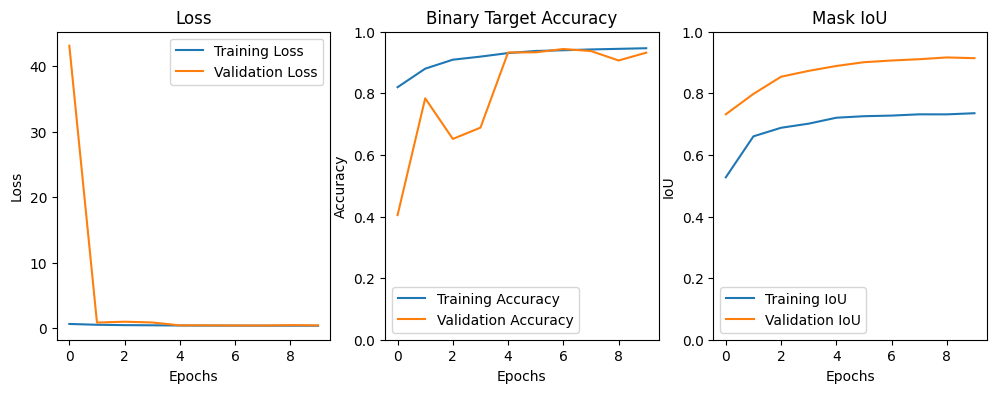

In [ ]:
history_df_csv=pd.read_csv(output_dir + 'history_unet.csv')
plot_learning_curves(history_df_csv)

# 6. Inference and Evaluation

In [ ]:
model.evaluate(test_dataset)

24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.4227 - mask_output_binary_io_u: 0.7219 - mask_output_loss: 0.5283 - target_output_accuracy: 0.9299 - target_output_auroc: 0.9799 - target_output_loss: 0.1763 - target_output_precision: 0.9646 - target_output_recall: 0.8496


[0.4244944751262665,
 0.5296114087104797,
 0.17846544086933136,
 0.7208797335624695,
 0.9334229826927185,
 0.9807590246200562,
 0.9700374603271484,
 0.861896812915802]

##Predictions on Test Data

In [ ]:
class_names = ['Healthy','Pneumonia']

In [ ]:
# Get the true classes (ground truth) from the test generator
true_classes = []

# Iterate over the test dataset
for (_, _),( _, target) in test_dataset:
    true_classes.append(target.numpy())  # Append each batch of target values

# Convert the list of true classes to a numpy array
true_classes = np.concatenate(true_classes, axis=0)

In [ ]:
# Get predictions from the model(probabilities of class 1)

predicted_mask_prob, predicted_classes_prob = model.predict(test_dataset)

# Convert predicted probabilities for the mask to binary values (0 or 1) using a threshold of 0.5
predicted_mask = (predicted_mask_prob > 0.5).astype(int)

# Convert predicted probabilities for the target classes to binary values (0 or 1) using a threshold of 0.5
predicted_classes_list = (predicted_classes_prob > 0.5).astype(int)
predicted_classes=np.concatenate(predicted_classes_list, axis=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 695ms/step


## Classification Report

In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes,target_names=class_names)
print(report)


              precision    recall  f1-score   support

     Healthy       0.91      0.98      0.95       886
   Pneumonia       0.97      0.86      0.91       601

    accuracy                           0.93      1487
   macro avg       0.94      0.92      0.93      1487
weighted avg       0.94      0.93      0.93      1487



##Confusion Matrix

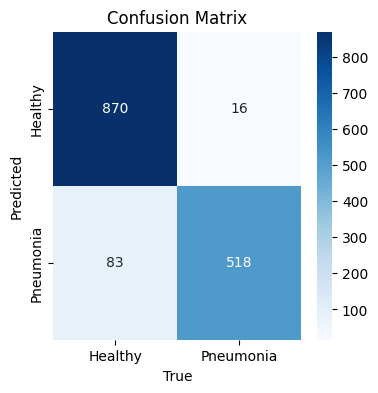

In [ ]:
plt.figure(figsize=(4,4))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=class_names,yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [ ]:
!ls /content


sample_data


In [ ]:
print(output_dir + 'model_unet.keras')

/contentmodel_unet.keras


##Visualization: True vs Predicted Masks

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


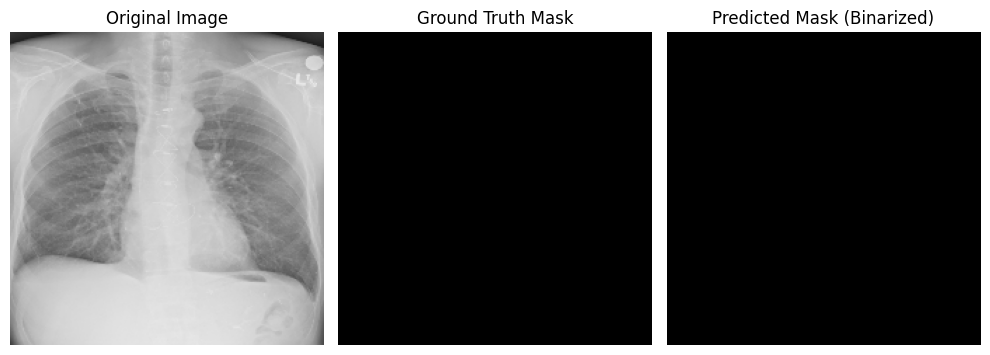

Ground Truth Target: 0, Predicted Target: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


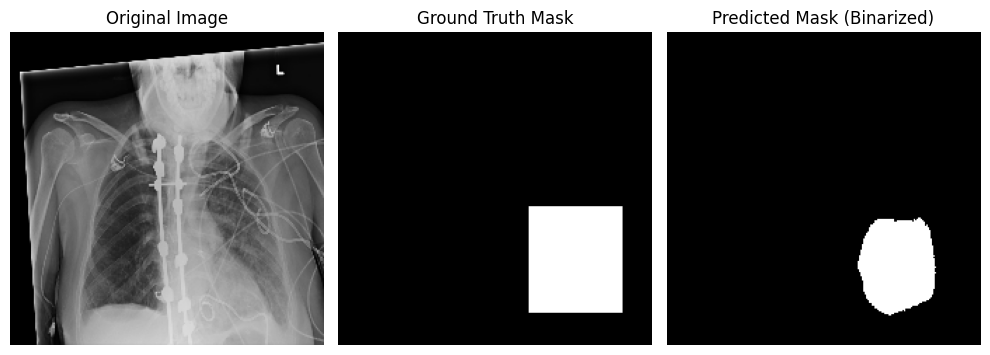

Ground Truth Target: 1, Predicted Target: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


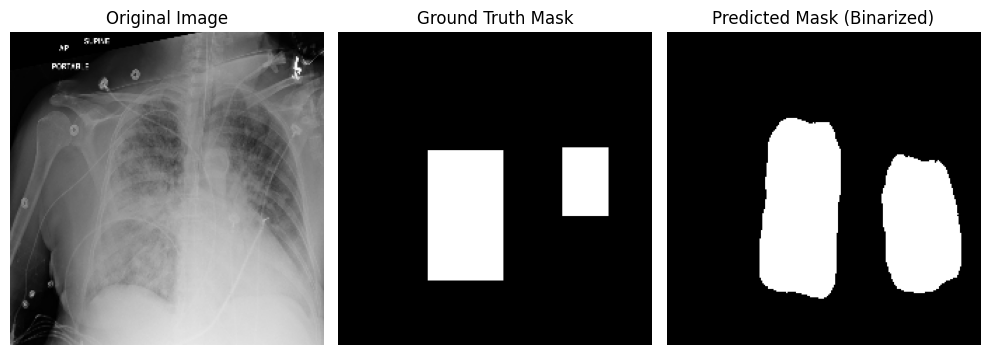

Ground Truth Target: 1, Predicted Target: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


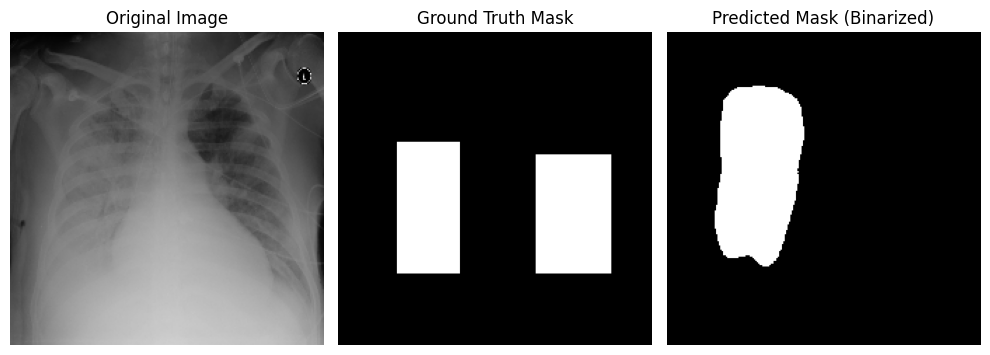

Ground Truth Target: 1, Predicted Target: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


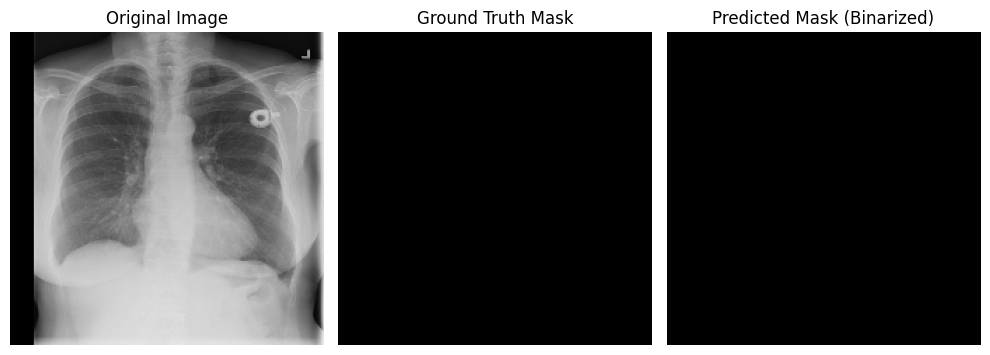

Ground Truth Target: 0, Predicted Target: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


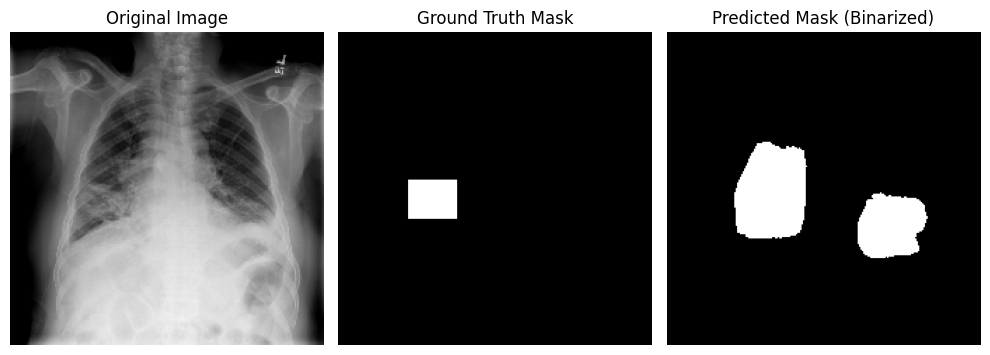

Ground Truth Target: 1, Predicted Target: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


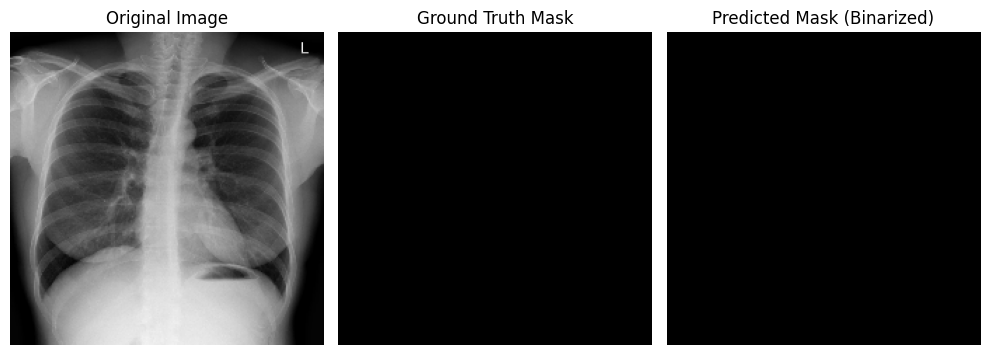

Ground Truth Target: 0, Predicted Target: 0


In [ ]:
visualize_predictions(dataset=test_dataset, model=model, num_samples=7)